In [1]:
# pip install pyarrow<15

In [2]:
# pip install --upgrade ibis-framework

In [3]:
# pip install -q datasets transformers evaluate

In [26]:
from transformers import pipeline
from PIL import Image
import requests

In [27]:
from huggingface_hub import notebook_login

notebook_login()

Read Data from HuggingFace repository

In [28]:
from datasets import load_dataset

ds = load_dataset('aslez123/fashion_dataset')
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [4]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x825>,
 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=550x825>}

In [5]:
train_ds = ds["train"]
val_ds = ds["validation"]

In [9]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

In [10]:
# train_ds = train_ds.map(lambda example: {'label': example['label'].convert('L')})
# val_ds = val_ds.map(lambda example: {'label': example['label'].convert('L')})


In [11]:
# val_ds[0]

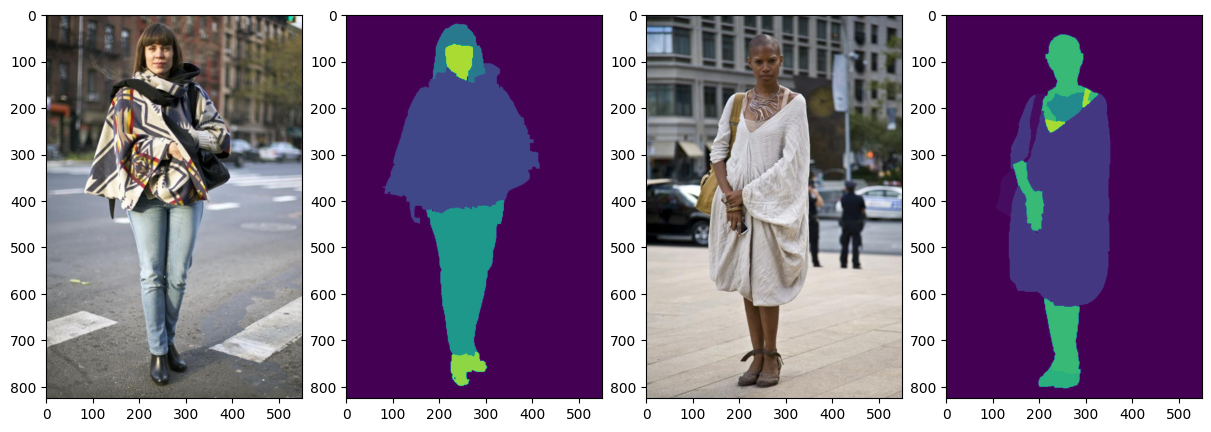

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,4, figsize=(12,12), constrained_layout=True)

axs[0].imshow(ds['validation'][5]['image'])
axs[1].imshow(ds['validation'][5]['label'])
axs[2].imshow(val_ds[43]['image'])
axs[3].imshow(val_ds[43]['label'])


Use the segmentation pipline to check how no fine-tuning model works with our data

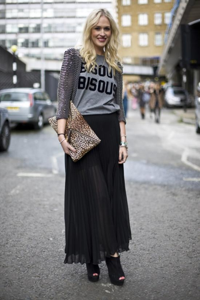

In [13]:
image = ds['validation'][15]['image']
image = image.resize((200, 300))
image

In [14]:
semantic_segmentation = pipeline("image-segmentation", "facebook/mask2former-swin-small-ade-semantic")
results = semantic_segmentation(image)
results

config.json:   0%|          | 0.00/82.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.999276,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=200x300>},
 {'score': 0.999044,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=200x300>},
 {'score': 0.997794,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=200x300>},
 {'score': 0.999754,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=200x300>}]

The segmentation pipeline output includes a mask for every predicted class. Our model doesn't recognise fashion, because it wasn't train on that kind of data. It predict only some general shapes like cars or buildings.

Now let's take a look at the mask for person. We have 4 masks, person has number 4.

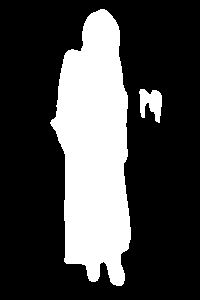

In [15]:
results[-1]["mask"]

Vizualization of every mask on one image.

Map the class integers to their class names.

In [6]:
import pandas as pd
classes_ds = pd.read_csv('labels.csv')

In [7]:
classes = list(classes_ds['label_list'])[1:]

In [8]:
id2label = {id: label for id, label in enumerate(classes)}
label2id = {label: id for id, label in enumerate(classes)}
num_labels = len(label2id)

Data Augumentation - to prevent overfitting, we perform data augmentation, which means we alter some pixels to create artificial data. I do this using the PyTorch library and ColorJitter.

In [10]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [11]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [12]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch['label']]
    inputs = image_processor(images, labels)
    return inputs

In [13]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)


In [14]:
train_ds[1]['labels']

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [39]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

In [2]:
# num_classes=[]
# for i in range(800):

#   non_255_values = train_ds[i]['labels'][train_ds[i]['labels'] != 255]
#   num_classes.append(max(non_255_values))

In [1]:
# max(num_classes)

In [ ]:
# train_ds[1]['pixel_values']

In [ ]:
# train_ds[6]['labels']

Evaluation with evaluate library

In [15]:
import evaluate

metric = evaluate.load("mean_iou")

In [16]:
import numpy as np
import torch
from torch import nn

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

Train

In [17]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
# model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.wei

In [18]:
# pip install transformers[torch]


In [19]:
# pip install accelerate -U

In [20]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 800
})

In [22]:

training_args = TrainingArguments(
    output_dir="segmentation-train",
    learning_rate=6e-5,
    num_train_epochs=5,
    save_total_limit=3,
    save_strategy="steps",
    save_steps=200,
    remove_unused_columns=False,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss
500,2.317200


TrainOutput(global_step=500, training_loss=2.317197998046875, metrics={'train_runtime': 410.8722, 'train_samples_per_second': 9.735, 'train_steps_per_second': 1.217, 'total_flos': 7.0417416978432e+16, 'train_loss': 2.317197998046875, 'epoch': 5.0})

In [23]:
trainer.push_to_hub()


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1709030599.7a9f12051d57.7793.1:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aslez123/segmentation-train/commit/21fd9d2ef48deb940a0d9b747340cc773923954a', commit_message='End of training', commit_description='', oid='21fd9d2ef48deb940a0d9b747340cc773923954a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
trainer.evaluate(val_ds)

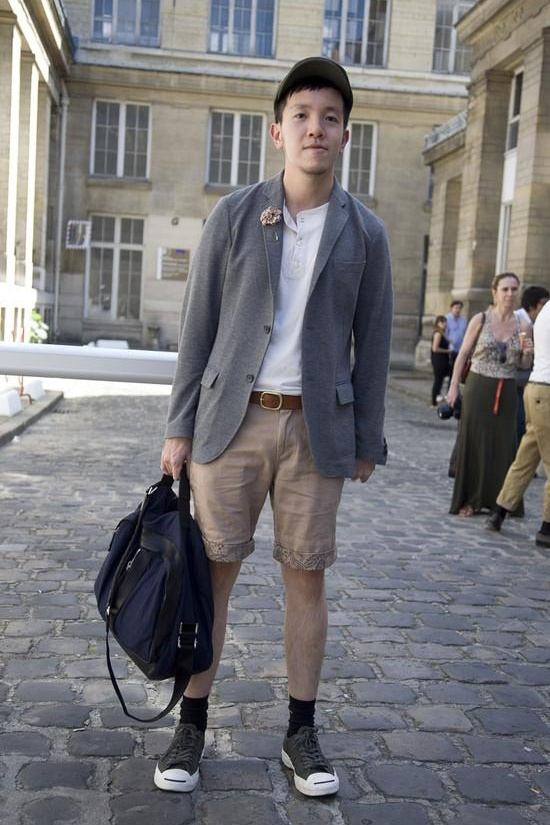

In [30]:
image = ds['validation'][66]["image"]
image

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

In [32]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

In [33]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [39]:
def create_ade20k_label_colormap():
 return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

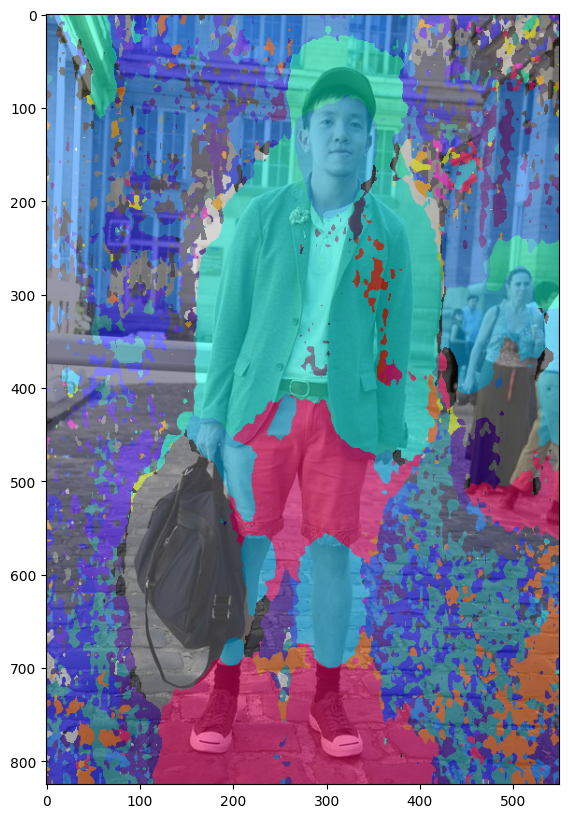

In [40]:
import matplotlib.pyplot as plt
import numpy as np


color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(create_ade20k_label_colormap())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()